In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_datareader import DataReader
from datetime import datetime
import yfinance as yf
import os

from tqdm import tqdm
from scipy.integrate import simps

## Draw Empirical Distributions Image

[*********************100%***********************]  6 of 6 completed


NVDA:
Mean: 31.725554102730303
Variance: 878.6597574724375
 
AMD:
Mean: 100.64815152442841
Variance: 1238.7420433775753
 
INTC:
Mean: 41.40178271331007
Variance: 97.46512812174609
 
QCOM:
Mean: 126.97301673564229
Variance: 935.4688779032149
 
AAPL:
Mean: 146.7570825216108
Variance: 1399.183121703289
 
AVGO:
Mean: 63.05962385310834
Variance: 1312.744301955262
 


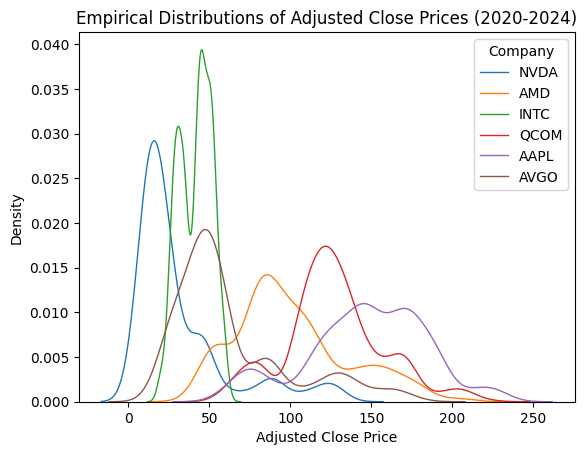

In [5]:
start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)

stock_symbols = ['NVDA', 'AMD', 'INTC', 'QCOM', 'AAPL', 'AVGO']
stocks= yf.download(stock_symbols, start_date, end_date)['Adj Close']

close_data = {}

for symbol in stock_symbols:
    X = stocks[symbol].values
    close_data[symbol] = X
    
    mean = np.mean(X)
    variance = np.var(X)
    
    print(f"{symbol}:")
    print(f"Mean: {mean}")
    print(f"Variance: {variance}")
    print(' ')
 
    sns.kdeplot(data=X, linewidth=1, label=symbol)
    
plt.title("Empirical Distributions of Adjusted Close Prices (2020-2024)")
plt.xlabel("Adjusted Close Price")
plt.ylabel("Density")
plt.legend(title="Company")
plt.show()

### 1. Set the initial value for the 5 parameter:
    -1 first, be sure about mu_1, mu_2, p from the image
    - second, find the basic value for sigma1, sigma2
    - 3, loop 
    - check result to find the best

In [2]:
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

In [3]:
def monte_carlo_simulation(mu_1, sigma1, 
                           mu_2, sigma2, 
                           p, T=1000):
    r = np.zeros(T)
    for t in range(T):
        eps1 = np.random.normal(0,1,1)
        eps2 = np.random.normal(0,1,1)
        r1 = mu_1 + sigma1 * eps1
        r2 = mu_2 + sigma2 * eps2
        u = np.random.uniform(0,1,1)
        r[t] = r1*(u <= p)+r2*(u > p)
    
    return r

def simulation_image(parameters, save_path):
    current_X, mu_1, sigma1, mu_2, sigma2, p =  parameters[0], parameters[1], parameters[2],parameters[3], parameters[4], parameters[5]
 
    plt.figure(figsize=(10,6))
    fig, ax = plt.subplots()
    sns.kdeplot(data=current_X, linewidth=4)
    initalR = monte_carlo_simulation(mu_1, sigma1, mu_2, sigma2, p, T=1000)
    plt.hist(initalR, bins=100, density=True, alpha=0.6, color='green', label="Histogram")
    ax.legend([f'Empirical Kernal Distribution: {save_path}', 'Mixture Model Simulated Distribution'])
    plt.title(f'Monte Carlo Simulation\n,sigma1={sigma1},sigma2={sigma2}')
    ## Save Image
    imagePath = os.path.join(save_path,f"{save_path},sigma1={sigma1},sigma2={sigma2}'.png")
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(imagePath)

def calculateOverlap(parameters):
    
    current_X, mu_1, sigma1, mu_2, sigma2, p =  parameters[0], parameters[1], parameters[2],parameters[3], parameters[4], parameters[5]
    r = monte_carlo_simulation(mu_1, sigma1, 
                               mu_2, sigma2, 
                          p)
    
    histArea, bin_edges = np.histogram(r, bins=100, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    
    kde = gaussian_kde(current_X)
    kdeArea = kde(bin_centers)
    
    overlap = np.minimum(histArea, kdeArea)
    return simps(overlap, bin_centers)

# Loop 

def optimize_parameters(parameters, save_path, step=5):
    bestArea = 0
    bestParam = []
    sigma1, sigma2 =  parameters[2], parameters[4]
    
    if sigma2>sigma1:
        sigma1_range = [i for i in range(sigma1-step, sigma1+step)]
        sigma2_range = [i for i in range(int(np.floor(sigma2-step*2)), sigma2+step*2)]
    
    else:
        sigma2_range = [i for i in range(sigma2-step, sigma2+step)]
        sigma1_range = [i for i in range(int(np.floor(sigma1-step*2)), sigma1+step*2)]
    
    for i in tqdm(sigma1_range):
        for j in sigma2_range:
            parameters[2] = i
            parameters[4] = j
            simulation_image(parameters, save_path)
            
            overlapArea = calculateOverlap(parameters)
            
            if bestArea <= overlapArea:
                bestParam = parameters
    return bestParam
    
#     simulation_image(bestParam, save_path)

### 1. Get mu_1, mu_2 and p
- **Choose mu1, mu2**: mu1 and mu2 value according to the valley points and the peak points

Peaks corresponding x values: [ 15.59546765  88.15090267 123.11737738]
Valleys corresponding x values: [ 68.91934158 105.63414003]


<Figure size 1000x600 with 0 Axes>

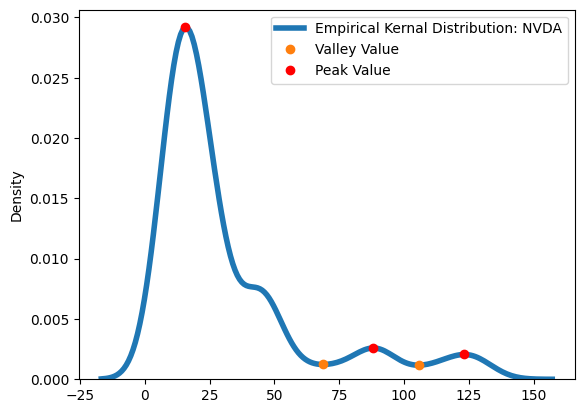

In [16]:
current_X = close_data['NVDA']
stock_symbol =  'NVDA'

# Plotting the histogram of r
plt.figure(figsize=(10,6))
fig, ax = plt.subplots()

# Calculate the peak value
sns_kde = sns.kdeplot(data=current_X , linewidth=4)
x, y = sns_kde.get_lines()[0].get_data()

peaks, _ = find_peaks(y)
peak_x_values = x[peaks]

valleys, _ = find_peaks(-y)  # Negate y to find valleys
valleys, _ = find_peaks(-y) 

print("Peaks corresponding x values:", x[peaks])
print("Valleys corresponding x values:", x[valleys])

plt.plot(x[valleys], y[valleys], "o", label='Valleys')  # Valleys marked in green
plt.plot(peak_x_values, y[peaks], "ro", label='Peaks')

ax.legend([f'Empirical Kernal Distribution: {stock_symbol}', 
           'Valley Value',
           'Peak Value'])

### 1. Get mu_1, mu_2 and p
- **Calculate P**: choose a cut point, divide the area under Empirical Kernal Distribution. according to the ratio of Specific Area divide Total Area

In [17]:
# calculate whole area
def calculate_p(cut_point):
    total_area = simps(y, x)
    print("Total Area:", total_area)

    # calculate specific area
    mask = (x >= 0) & (x <= cut_point)
    area_between = simps(y[mask], x[mask])
    print("Specific Area :", area_between)

    p = area_between/total_area
    print("Probability:",p)
    
    return p

In [18]:
cut_point = 68.91934158
p = calculate_p(cut_point)

Total Area: 0.9999350371098361
Specific Area : 0.8454978705910676
Probability: 0.8455528001447512


## 2. choose initial sigma1, sigma2

In [ ]:
mu_1, sigma1, mu_2, sigma2, p

In [19]:
intcP = [close_data['INTC'], 30, 4, 45, 7, 0.39]
nvdiaP = [close_data['NVDA'], 16, 20, 88, 40, 0.8455528001447512]
parameters = nvdiaP
stock_symbol="nvda"

<Figure size 1000x600 with 0 Axes>

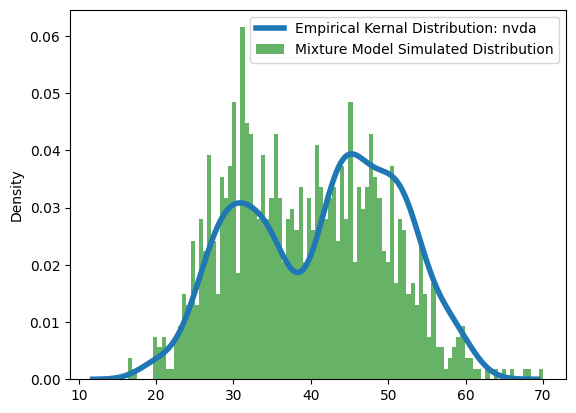

In [52]:
current_X, mu_1, sigma1, mu_2, sigma2, p =  intcP = close_data['INTC'], 30, 4, 45, 7, 0.39
initalR = monte_carlo_simulation(mu_1, sigma1, mu_2, sigma2, p, T=1000)

plt.figure(figsize=(10,6))
fig, ax = plt.subplots()
sns.kdeplot(data=current_X, linewidth=4)
plt.hist(initalR, bins=100, density=True, alpha=0.6, color='green', label="Histogram")
ax.legend([f'Empirical Kernal Distribution: {stock_symbol}', 'Mixture Model Simulated Distribution'])

## 3. repeat 1-2 to finish all the parameters

In [ ]:
nvdiaP = [close_data['NVDA'], 16, 13, 88, 35, 0.8]
amdP = [close_data['AMD'], 86.20013076, 25, 151.50455195, 24, 0.8200047346930525]
intcP = [close_data['INTC'], 30, 4, 45, 7, 0.39]
qcomP = [close_data['QCOM'], 70, 15, 123, 27, 0.15]
aaplP = [close_data['AAPL'], 70, 19, 154, 34,0.15]
avgoP = [close_data['AVGO'], 45, 19, 128, 34, 0.82]

initialParams = dict(zip(stock_symbols, [nvdiaP, amdP, intcP, qcomP, aaplP, avgoP]))
bestParam = {}
for company, params in initialParams.items():
    best_param = optimize_parameters(params, company, step=7)
    bestParam[company] = best_param

In [59]:
pd.DataFrame(bestParam).drop(index=0).T

,1,2,3,4,5
NVDA,16,19,88,48,0.8
AMD,86.200131,38,151.504552,30,0.820005
INTC,30,10,45,20,0.39
QCOM,70,21,123,40,0.15
AAPL,70,25,154,47,0.15
AVGO,45,25,128,47,0.82


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

# Define the function for the Monte Carlo stock price simulation
def monte_carlo_stock_price_interactive(S0=100, mu=0.05, sigma=0.2, T=1, N=252, num_simulations=100):
    """
    Interactive Monte Carlo simulation for stock price based on Geometric Brownian Motion.

    Parameters:
    S0: Initial stock price
    mu: Expected return
    sigma: Volatility
    T: Time period (in years)
    N: Number of time steps (daily steps for 1 year)
    num_simulations: Number of simulations

    Returns:
    None (plots the stock price simulations)
    """

    # Time step size
    dt = T / N

    # Running Monte Carlo simulations
    simulations = np.zeros((num_simulations, N))
    for i in range(num_simulations):
        # Generate random changes based on normal distribution
        rand_changes = np.random.normal(mu * dt, sigma * np.sqrt(dt), N)
        # Simulate the price path
        simulations[i, :] = S0 * np.exp(np.cumsum(rand_changes))

    # Plotting the simulations
    plt.figure(figsize=(10, 6))
    for i in range(num_simulations):
        plt.plot(simulations[i, :], color='lightblue', linewidth=0.5)
    plt.xlabel('Time Step (Days)')
    plt.ylabel('Stock Price')
    plt.title(f'Monte Carlo Simulations of Stock Price\nS0={S0}, mu={mu}, sigma={sigma}, T={T}, N={N}, simulations={num_simulations}')
    plt.show()

# Create sliders to change parameters interactively
interact(
    monte_carlo_stock_price_interactive,
    S0=FloatSlider(value=100, min=50, max=150, step=1, description='Initial Price S0'),
    mu=FloatSlider(value=0.05, min=-0.1, max=0.1, step=0.01, description='Expected Return (mu)'),
    sigma=FloatSlider(value=0.2, min=0.05, max=0.5, step=0.01, description='Volatility (sigma)'),
    T=FloatSlider(value=1, min=0.5, max=5, step=0.5, description='Time Period (T)'),
    N=IntSlider(value=252, min=50, max=500, step=10, description='Time Steps (N)'),
    num_simulations=IntSlider(value=100, min=10, max=500, step=10, description='Simulations')
)
